In [1]:
import re
import requests
import json
from bs4 import BeautifulSoup 
import random
import numpy as np
from IPython.core.display import HTML
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import locale
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [3]:
CIKNumber = '0000037996' #'0001341439,0001326801,0000104169, 0001018724, 0000027419, 0000037996, 0001364742'
strippedCIKNumber = CIKNumber.lstrip("0")
filingType = "10-K"
baseURL = "https://www.sec.gov"

filingParameters = {'action':'getcompany',
                                  'CIK':CIKNumber,
                                  'type':filingType,
                                  'dateb':'',
                                  'owner':'exclude',
                                  'start':'',
                                  'output':'',
                                  'count':'100'}

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}



In [4]:
##Get financial data for a particular company from the companyfacts API
apiResponse = requests.get(f"https://data.sec.gov/api/xbrl/companyfacts/CIK{CIKNumber}.json", headers=header)

if apiResponse.ok:
    apiData = json.loads(apiResponse.content)
    print(f"Company Name: {apiData['entityName']}")
else:
    print(apiResponse.status_code)
    print(apiResponse.reason)

Company Name: Ford Motor Co


In [6]:
#get the report schema document for the particular company
submissionsResponse = requests.get(f"https://data.sec.gov/submissions/CIK{CIKNumber}.json", headers=header)

if submissionsResponse.ok:
    submissionsData = json.loads(submissionsResponse.content)
else:
    print(submissionsResponse.status_code)
    print(submissionsResponse.reason)

#prepare data from submissions API to extract accession number and file pre-fix from 10-Q and 10-K reports
submissionsDf = pd.DataFrame(submissionsData["filings"]["recent"])
submissionsDf = submissionsDf[submissionsDf["form"].isin(["10-Q","10-K"])]
submissionsDf["accessionNumber"] = submissionsDf["accessionNumber"].apply(lambda number: number.replace("-",""))
submissionsDf["primaryDocument"] = submissionsDf["primaryDocument"].apply(lambda doc: doc.replace(".htm",""))
submissionsDf.sort_values(by="filingDate")

#create the archives URL for the _cal.xml report schema document
mostRecentReport = submissionsDf.iloc[0]
archivesPath = f"""/Archives/edgar/data/{strippedCIKNumber}/{mostRecentReport["accessionNumber"]}/{mostRecentReport["primaryDocument"]}_cal.xml"""
    
# request the url, and then parse the response.
#companyResponse = requests.get(url=r"https://www.sec.gov/cgi-bin/browse-edgar", params=filingParameters, headers=header)

#print(response.content)
#companyParser = BeautifulSoup(companyResponse.content, 'html.parser')
#documentLink = companyParser.find("a", {"id":"documentsbutton"})
#print(baseURL + documentLink["href"])

#documentResponse = requests.get(baseURL + documentLink["href"], headers=header)
#print(documentResponse.content)

#documentParser = BeautifulSoup(documentResponse.content, 'html.parser')
#xmlTable = documentParser.find("table", {"summary":"Data Files"})
#xmlTableData = xmlTable.find_all("td", {"scope":"row"})

#xmlSchemaData = None

#i=0

#while i < len(xmlTableData):
#    if xmlTableData[i].getText() == "XBRL TAXONOMY EXTENSION CALCULATION LINKBASE DOCUMENT":
#        xmlSchemaData = xmlTableData[i+1].find("a")
#        break
#    
#    i+=1
    
#print(baseURL + xmlSchemaData["href"])

print(baseURL + archivesPath)
schemaReportResponse = requests.get(baseURL + archivesPath, headers=header)
#print(schemaReportResponse.content)


https://www.sec.gov/Archives/edgar/data/37996/000003799623000068/f-20230930_cal.xml


In [7]:
schemaReportParser = BeautifulSoup(schemaReportResponse.content, features="xml")
financialStatements = schemaReportParser.find_all("link:calculationLink", {"xlink:type":"extended"})

data = {"statement": []}

for statement in financialStatements:
    statementName = statement["xlink:role"].split("role/")[1]
    
    if statementName.startswith("Role_"):
        try:
            statementName = statementName.split("Role_")[1]
        except:
            continue

    statementDictionary = {"name":statementName, "concept": []}
    
    concepts = statement.find_all("link:calculationArc", {"xlink:type":"arc"})
    
    for concept in concepts:
        try:
            sectionName = re.search(r"\w*us-gaap_([a-zA-Z0-9]*)_?.*$",concept["xlink:from"]).group(1)
            conceptName = re.search(r"\w*us-gaap_([a-zA-Z0-9]*)_?.*$",concept["xlink:to"]).group(1)
            conceptDictionary = {"section": sectionName, \
                                 "name": conceptName, \
                                 "data": apiData["facts"]["us-gaap"][conceptName]}
        except:
            try:
                conceptDictionary = {"section":concept["xlink:from"], "name":concept["xlink:to"], \
                                     "data":apiData["facts"]["us-gaap"][concept["xlink:to"].split("us-gaap_")[1]]}
            except:
                continue
        finally:
            statementDictionary["concept"].append(conceptDictionary)
    
    data["statement"].append(statementDictionary)

# Print Struncture
    # print()
    # print("-------------------")
    # print(f'Statement Name: {statementName}')
    # for concept in concepts:
    #     try:
    #         sectionName = re.search(r"\w*us-gaap_([a-zA-Z0-9]*)_?.*$",concept["xlink:from"]).group(1)
    #         conceptName = re.search(r"\w*us-gaap_([a-zA-Z0-9]*)_?.*$",concept["xlink:to"]).group(1)
    #         print(f'Section Name: {sectionName}')
    #         print(f'Concept Name: {conceptName}')
    #     except:
    #         continue

# print(data)

# Compancy Name: Oracle Corporation
# https://www.sec.gov/Archives/edgar/data/1341439/000095017023028914/0000950170-23-028914-index.htm
# https://www.sec.gov/Archives/edgar/data/1341439/000095017023028914/orcl-20230531_cal.xml
# FS: us-gaap_LiabilitiesAndStockholdersEquity
# Concept: us-gaap_StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest

# Compancy Name: Meta Platforms, Inc.
# https://www.sec.gov/Archives/edgar/data/1326801/000132680123000013/0001326801-23-000013-index.htm
# https://www.sec.gov/Archives/edgar/data/1326801/000132680123000013/meta-20221231_cal.xml
# FS: loc_us-gaap_StockholdersEquity_d91831d7-4445-486b-8720-eef0838228c6
# Concept: loc_us-gaap_CommonStockValue_4bbe192a-2f70-4746-b214-ffcde0a70cb6

# Compancy Name: WALMART INC.
# https://www.sec.gov/Archives/edgar/data/104169/000010416923000020/0000104169-23-000020-index.htm
# https://www.sec.gov/Archives/edgar/data/104169/000010416923000020/wmt-20230131_cal.xml
# FS: loc_us-gaap_ProfitLoss_9f64ec3f-f5d4-4eff-9cd4-01674db524d4
# Concept: loc_us-gaap_IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_20eda8ed-37d3-4ba1-8c87-739b2906f134

# Compancy Name: AMAZON.COM, INC.
# https://www.sec.gov/Archives/edgar/data/1018724/000101872423000004/0001018724-23-000004-index.htm
# https://www.sec.gov/Archives/edgar/data/1018724/000101872423000004/amzn-20221231_cal.xml
# FS: loc_us-gaap_NetCashProvidedByUsedInFinancingActivities_3816386b-0fc0-412e-9a41-01122928647f
# Concept: loc_us-gaap_ProceedsFromIssuanceOfLongTermDebt_a8a81f73-b463-4514-aa94-f82335360f28

# Compancy Name: TARGET CORPORATION
# https://www.sec.gov/Archives/edgar/data/27419/000002741923000015/0000027419-23-000015-index.htm
# https://www.sec.gov/Archives/edgar/data/27419/000002741923000015/tgt-20230128_cal.xml
# FS: loc_us-gaap_OperatingIncomeLoss_5e38cd4d-4123-447e-8077-563b5f255431
# Concept: loc_us-gaap_CostOfGoodsAndServicesSold_db875d1d-3248-4cbf-a03d-f87d377120bb

# def extractConcept(val):

In [8]:
for fs in data["statement"]:
    print(fs["name"])
    print(f'Count of Concepts: {len(fs["concept"])}')

CONSOLIDATEDSTATEMENTOFCASHFLOWS
Count of Concepts: 37
CONSOLIDATEDINCOMESTATEMENT
Count of Concepts: 16
CONSOLIDATEDSTATEMENTSOFCOMPREHENSIVEINCOME
Count of Concepts: 8
CONSOLIDATEDBALANCESHEETS
Count of Concepts: 29
OtherIncomeLossDetails
Count of Concepts: 8
CapitalStockandEarningsPerShareDetails
Count of Concepts: 2
CashCashEquivalentsandMarketableSecuritiesRestrictedCashDetails
Count of Concepts: 2
InventoriesDetails
Count of Concepts: 2
OtherLiabilitiesandDeferredRevenueDetails
Count of Concepts: 15
RetirementBenefitsExpenseDetails
Count of Concepts: 7
DebtDebtOutstandingDetails
Count of Concepts: 2
BalanceSheetEffectofDerivativeFinancialInstrumentsDetails
Count of Concepts: 4
AccumulatedOtherComprehensiveIncomeLossDetails
Count of Concepts: 23


In [9]:
financialStatementIndex = 0
print(data["statement"][financialStatementIndex]["name"])
print(f'Count of Concepts: {len(data["statement"][financialStatementIndex]["concept"])}')

CONSOLIDATEDSTATEMENTOFCASHFLOWS
Count of Concepts: 37


In [10]:
features = []
revFound = False
revIndex = 0
for index, con in enumerate(data["statement"][financialStatementIndex]["concept"]):
    print(f'Section: {con["section"]}')
    print(f'Name: {con["name"]}')
    print(f'data label: {con["data"]["label"]}')
    print(f'data Description: {con["data"]["description"]}')
    print()
    features.append(con)
    revFound = True if con["name"] == "Revenues" else False
    revIndex = index if con["name"] == "Revenues" else revIndex
# data["statement"][3]["concept"]
if not revFound:
    # Check existence of Revenue Key. If not available delete
    if "Revenues" in list(apiData["facts"]["us-gaap"]):
        features.append({"name":"Revenues","Name":"Revenues","Description":"Revenues","data":apiData["facts"]["us-gaap"]["Revenues"]})
        revIndex = len(features)-1
    else:
        raise Exception("No Revenue Data found")

Section: NetCashProvidedByUsedInOperatingActivities
Name: IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities
data label: Increase (Decrease) in Accounts Payable and Other Operating Liabilities
data Description: Amount of increase (decrease) in obligations incurred but not paid, and operating obligations classified as other.

Section: NetCashProvidedByUsedInOperatingActivities
Name: Depreciation
data label: Depreciation
data Description: The amount of expense recognized in the current period that reflects the allocation of the cost of tangible assets over the assets' useful lives. Includes production and non-production related depreciation.

Section: NetCashProvidedByUsedInOperatingActivities
Name: AdjustmentForAmortization
data label: Amortization
data Description: The aggregate amount of recurring noncash expense charged against earnings in the period to allocate the cost of assets over their estimated remaining economic lives.

Section: NetCashProvidedByUsedInOperatingActi

In [11]:
financialData = {}
for feature in features:
    print(feature["name"])
    unit = "USD"
    if not unit in list(feature["data"]["units"]):
        if len(list(feature["data"]["units"])) == 1:
            unit = list(feature["data"]["units"])[0]
        else:
            unit = "USD/shares"
        
    for element in feature["data"]["units"][unit]:
        if element["end"] in financialData:
            financialData[element["end"]][feature["name"]] = element["val"]
        else:
            financialData[element["end"]] = {f'{feature["name"]}': element["val"]} 
    print(f"{feature['name']} processed successfully")

# for year in financialData:
#     if "LiabilitiesCurrent" in financialData[year] and "LiabilitiesNoncurrent" in financialData[year] and "StockholdersEquity" in financialData[year]:
#         financialData[year]["DebtToEquityRatio"] = (financialData[year]["LiabilitiesCurrent"] + financialData[year]["LiabilitiesNoncurrent"]) / financialData[year]["StockholdersEquity"]
        
#     if "LiabilitiesCurrent" in financialData[year] and "LiabilitiesNoncurrent" in financialData[year] and "AssetsCurrent" in financialData[year]:
#         financialData[year]["CurrentRatio"] = financialData[year]["LiabilitiesCurrent"] / financialData[year]["AssetsCurrent"]

IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities
IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities processed successfully
Depreciation
Depreciation processed successfully
AdjustmentForAmortization
AdjustmentForAmortization processed successfully
PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash
PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash processed successfully
ProfitLoss
ProfitLoss processed successfully
ProvisionForLoanLeaseAndOtherLosses
ProvisionForLoanLeaseAndOtherLosses processed successfully
IncreaseDecreaseInAccountsReceivableAndOtherOperatingAssets
IncreaseDecreaseInAccountsReceivableAndOtherOperatingAssets processed successfully
ShareBasedCompensation
ShareBasedCompensation processed successfully
IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions
IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions processed successfully
IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistri

In [12]:
len(financialData)

63

In [13]:
print(financialData[list(financialData)[0]])

{'IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities': 6786000000, 'Depreciation': 6930000000, 'AdjustmentForAmortization': -626000000, 'PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash': -387000000, 'ProfitLoss': 993000000, 'ProvisionForLoanLeaseAndOtherLosses': 125000000, 'IncreaseDecreaseInAccountsReceivableAndOtherOperatingAssets': 2126000000, 'ShareBasedCompensation': 199000000, 'IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions': -15000000, 'IncreaseDecreaseInInventoriesAndOtherOperatingAssets': 2360000000, 'GainsLossesOnExtinguishmentOfDebt': 0, 'OtherOperatingActivitiesCashFlowStatement': -36000000, 'DeferredIncomeTaxExpenseBenefit': -82000000, 'DisposalGroupNotDiscontinuedOperationLossGainOnWriteDown': 0, 'IncreaseDecreaseInFinanceReceivables': -746000000, 'ForeignCurrencyTransactionGainLossBeforeTax': -476000000, 'PaymentsOfDividendsCommonStock': 2308000000, 'PaymentsForRepurchaseOfCommonStock': 164000000, 'ProceedsFromRepayment

In [14]:
dfData = []
for row in financialData:
    record = financialData[row]
    record["Quarter"]= row
    record["Revenue Increased"] = random.choice([0,1])
    dfData.append(record)
    
financialDataDF = pd.DataFrame(dfData)

In [15]:
financialDataDF.head(10)

,IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities,Depreciation,AdjustmentForAmortization,PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash,ProfitLoss,ProvisionForLoanLeaseAndOtherLosses,IncreaseDecreaseInAccountsReceivableAndOtherOperatingAssets,ShareBasedCompensation,IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions,IncreaseDecreaseInInventoriesAndOtherOperatingAssets,...,ProceedsFromSaleAndMaturityOfMarketableSecurities,ProceedsFromCollectionOfFinanceReceivables,PaymentsForProceedsFromDerivativeInstrumentInvestingActivities,PaymentsToAcquireMarketableSecurities,Revenues,Quarter,Revenue Increased,GainLossOnInvestments,ProceedsFromDivestitureOfInterestInConsolidatedSubsidiaries,PaymentsToAcquireEquityMethodInvestments
0,6.786000e+09,6.930000e+09,-6.260000e+08,-3.870000e+08,993000000,125000000.0,2.126000e+09,199000000.0,-15000000.0,2.360000e+09,...,1.734100e+10,3.841800e+10,-290000000.0,1.454700e+10,3.766600e+10,2018-09-30,1,NaN,NaN,NaN
1,2.944000e+09,2.429000e+09,-2.870000e+08,-1.800000e+07,1183000000,43000000.0,2.370000e+08,85000000.0,-17000000.0,1.083000e+09,...,4.441000e+09,1.233600e+10,14000000.0,3.923000e+09,4.034200e+10,2019-03-31,1,67000000.0,0.000000e+00,NaN
2,4.929000e+09,4.988000e+09,-5.870000e+08,1.230000e+08,150000000,166000000.0,9.620000e+08,169000000.0,-21000000.0,1.180000e+09,...,8.540000e+09,2.497400e+10,-83000000.0,7.670000e+09,3.885300e+10,2019-06-30,1,-187000000.0,0.000000e+00,NaN
3,5.226000e+09,7.310000e+09,-8.910000e+08,4.010000e+08,423000000,292000000.0,1.023000e+09,238000000.0,-73000000.0,1.790000e+09,...,1.253200e+10,3.785400e+10,-163000000.0,1.236700e+10,3.699000e+10,2019-09-30,0,199000000.0,0.000000e+00,NaN
4,1.940000e+08,2.444000e+09,-3.020000e+08,-1.780000e+08,-1993000000,598000000.0,-3.900000e+07,38000000.0,-118000000.0,1.177000e+09,...,4.998000e+09,1.270900e+10,-131000000.0,8.244000e+09,3.432000e+10,2020-03-31,1,-32000000.0,1.340000e+09,NaN
5,-2.485000e+09,4.802000e+09,-5.900000e+08,-4.540000e+08,1118000000,779000000.0,-2.200000e+08,107000000.0,-169000000.0,-6.600000e+07,...,1.080400e+10,2.292300e+10,-73000000.0,1.962400e+10,1.937100e+10,2020-06-30,1,47000000.0,1.340000e+09,NaN
6,3.858000e+09,6.670000e+09,-9.380000e+08,-4.540000e+08,2390000000,866000000.0,-7.400000e+07,170000000.0,-132000000.0,2.020000e+08,...,2.440200e+10,3.653600e+10,407000000.0,2.740100e+10,3.750100e+10,2020-09-30,1,297000000.0,1.340000e+09,NaN
7,6.809000e+09,8.751000e+09,-1.294000e+09,1.027000e+09,-1276000000,929000000.0,NaN,199000000.0,-130000000.0,NaN,...,3.239500e+10,4.874600e+10,323000000.0,3.962400e+10,3.595200e+10,2020-12-31,1,315000000.0,1.340000e+09,4000000.0
8,1.930000e+08,2.103000e+09,-3.610000e+08,-3.180000e+08,3262000000,-36000000.0,5.880000e+08,41000000.0,-68000000.0,2.176000e+09,...,1.168600e+10,1.248200e+10,-31000000.0,1.158000e+10,3.622800e+10,2021-03-31,1,899000000.0,7.000000e+06,NaN
9,-6.438000e+09,3.639000e+09,-7.150000e+08,-8.080000e+08,553000000,-196000000.0,9.050000e+08,183000000.0,-52000000.0,2.929000e+09,...,2.385300e+10,2.678200e+10,205000000.0,1.759300e+10,2.675200e+10,2021-06-30,0,7000000.0,1.440000e+08,NaN


In [16]:
financialDataDF.set_index("Quarter", inplace=True)
financialDataDF.fillna(0, inplace=True)
financialDataDF.shape

(63, 38)

In [17]:
financialDataDF.isnull().sum()

IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities                          0
Depreciation                                                                           0
AdjustmentForAmortization                                                              0
PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash                   0
ProfitLoss                                                                             0
ProvisionForLoanLeaseAndOtherLosses                                                    0
IncreaseDecreaseInAccountsReceivableAndOtherOperatingAssets                            0
ShareBasedCompensation                                                                 0
IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions                     0
IncreaseDecreaseInInventoriesAndOtherOperatingAssets                                   0
GainsLossesOnExtinguishmentOfDebt                                                      0
OtherOperatingActivit

In [18]:
# Update Revenue Increased column based on data
Revenue_Index_no = financialDataDF.columns.get_loc("Revenues")
RI_Index_no = financialDataDF.columns.get_loc("Revenue Increased")

for i in range(len(financialDataDF)):
    if i == 0:
        financialDataDF.iloc[i, RI_Index_no] = 0
    else:
        financialDataDF.iloc[i, RI_Index_no] = 1 if financialDataDF.iloc[i, Revenue_Index_no] > financialDataDF.iloc[i-1, Revenue_Index_no] else 0
financialDataDF[["Revenues","Revenue Increased"]].head(10)

,Revenues,Revenue Increased
Quarter,,
2018-09-30,3.766600e+10,0
2019-03-31,4.034200e+10,1
2019-06-30,3.885300e+10,0
2019-09-30,3.699000e+10,0
2020-03-31,3.432000e+10,0
2020-06-30,1.937100e+10,0
2020-09-30,3.750100e+10,1
2020-12-31,3.595200e+10,0
2021-03-31,3.622800e+10,1


In [19]:
# Separator data in predictors(x) and labels(y)
predictors = financialDataDF.loc[:,financialDataDF.columns != "Revenue Increased"]
labels = financialDataDF.loc[:,"Revenue Increased"]
predictors.head(20)

,IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities,Depreciation,AdjustmentForAmortization,PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash,ProfitLoss,ProvisionForLoanLeaseAndOtherLosses,IncreaseDecreaseInAccountsReceivableAndOtherOperatingAssets,ShareBasedCompensation,IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions,IncreaseDecreaseInInventoriesAndOtherOperatingAssets,...,PaymentsToAcquireProductiveAssets,PaymentsToAcquireLoansAndLeasesHeldForInvestment,ProceedsFromSaleAndMaturityOfMarketableSecurities,ProceedsFromCollectionOfFinanceReceivables,PaymentsForProceedsFromDerivativeInstrumentInvestingActivities,PaymentsToAcquireMarketableSecurities,Revenues,GainLossOnInvestments,ProceedsFromDivestitureOfInterestInConsolidatedSubsidiaries,PaymentsToAcquireEquityMethodInvestments
Quarter,,,,,,,,,,,,,,,,,,,,,
2018-09-30,6.786000e+09,6.930000e+09,-6.260000e+08,-3.870000e+08,993000000,125000000.0,2.126000e+09,199000000.0,-1.500000e+07,2.360000e+09,...,5669000000,48227000000,1.734100e+10,3.841800e+10,-290000000.0,1.454700e+10,3.766600e+10,0.000000e+00,0.000000e+00,0.000000e+00
2019-03-31,2.944000e+09,2.429000e+09,-2.870000e+08,-1.800000e+07,1183000000,43000000.0,2.370000e+08,85000000.0,-1.700000e+07,1.083000e+09,...,1633000000,12595000000,4.441000e+09,1.233600e+10,14000000.0,3.923000e+09,4.034200e+10,6.700000e+07,0.000000e+00,0.000000e+00
2019-06-30,4.929000e+09,4.988000e+09,-5.870000e+08,1.230000e+08,150000000,166000000.0,9.620000e+08,169000000.0,-2.100000e+07,1.180000e+09,...,3553000000,26202000000,8.540000e+09,2.497400e+10,-83000000.0,7.670000e+09,3.885300e+10,-1.870000e+08,0.000000e+00,0.000000e+00
2019-09-30,5.226000e+09,7.310000e+09,-8.910000e+08,4.010000e+08,423000000,292000000.0,1.023000e+09,238000000.0,-7.300000e+07,1.790000e+09,...,5358000000,41142000000,1.253200e+10,3.785400e+10,-163000000.0,1.236700e+10,3.699000e+10,1.990000e+08,0.000000e+00,0.000000e+00
2020-03-31,1.940000e+08,2.444000e+09,-3.020000e+08,-1.780000e+08,-1993000000,598000000.0,-3.900000e+07,38000000.0,-1.180000e+08,1.177000e+09,...,1780000000,12184000000,4.998000e+09,1.270900e+10,-131000000.0,8.244000e+09,3.432000e+10,-3.200000e+07,1.340000e+09,0.000000e+00
2020-06-30,-2.485000e+09,4.802000e+09,-5.900000e+08,-4.540000e+08,1118000000,779000000.0,-2.200000e+08,107000000.0,-1.690000e+08,-6.600000e+07,...,2955000000,27113000000,1.080400e+10,2.292300e+10,-73000000.0,1.962400e+10,1.937100e+10,4.700000e+07,1.340000e+09,0.000000e+00
2020-09-30,3.858000e+09,6.670000e+09,-9.380000e+08,-4.540000e+08,2390000000,866000000.0,-7.400000e+07,170000000.0,-1.320000e+08,2.020000e+08,...,4211000000,43473000000,2.440200e+10,3.653600e+10,407000000.0,2.740100e+10,3.750100e+10,2.970000e+08,1.340000e+09,0.000000e+00
2020-12-31,6.809000e+09,8.751000e+09,-1.294000e+09,1.027000e+09,-1276000000,929000000.0,0.000000e+00,199000000.0,-1.300000e+08,0.000000e+00,...,5742000000,55901000000,3.239500e+10,4.874600e+10,323000000.0,3.962400e+10,3.595200e+10,3.150000e+08,1.340000e+09,4.000000e+06
2021-03-31,1.930000e+08,2.103000e+09,-3.610000e+08,-3.180000e+08,3262000000,-36000000.0,5.880000e+08,41000000.0,-6.800000e+07,2.176000e+09,...,1368000000,11695000000,1.168600e+10,1.248200e+10,-31000000.0,1.158000e+10,3.622800e+10,8.990000e+08,7.000000e+06,0.000000e+00


In [20]:
# pca = PCA(n_components=3)
pca = PCA()
predictorspca = pca.fit_transform(predictors)
print(pca.explained_variance_ratio_.round(decimals=3))
# predictorspca[0:5]

# Find the number of components required to explain 95% of the variance
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
varThresh = 95
# Find the number of components required to explain 95% of the variance
num_components_95_variance = np.argmax(cumulative_variance_ratio >= (varThresh/100)) + 1
print(f'Num of components required to maintain {varThresh}% variance: {num_components_95_variance}')

[0.574 0.217 0.106 0.048 0.025 0.012 0.005 0.005 0.003 0.001 0.001 0.001
 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.   ]
Num of components required to maintain 95% variance: 5


1.0
0.5625


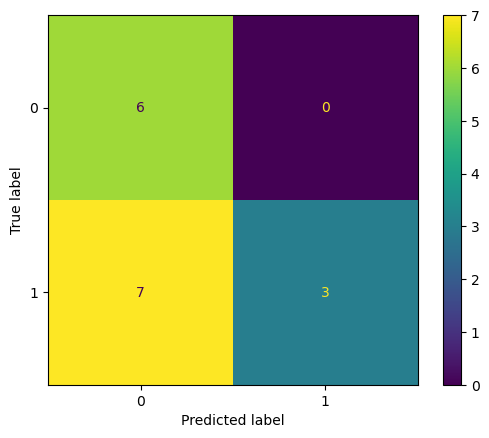

In [21]:
XTrain, XTest, yTrain, yTest = train_test_split(predictors,labels, random_state=3)

model = ensemble.RandomForestClassifier()

model.fit(XTrain,yTrain)

print(model.score(XTrain,yTrain))

print(model.score(XTest,yTest))

yPred = model.predict(XTest)

ConfusionMatrixDisplay(confusion_matrix(yTest, yPred), display_labels=model.classes_).plot()